### Task 2 - Temporal Network Analysis - January 2018
#### <i>Abdel K. Bokharouss, Joris Rombouts, Bart van Helvert, Remco Surtel</i>

### <font color = "green">imports and preparation</font>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import tkinter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [3]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [4]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [5]:
#test function for unix time stamps to datetime
print(
    datetime.datetime.fromtimestamp(
        int("1028243088")
    ).strftime('%Y-%m-%d %H:%M:%S')
)

2002-08-02 01:04:48


In [6]:
temp_nw.head()

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44


In [7]:
temp_nw.shape

(4729035, 4)

In [8]:
fh = open("data/tgraph_real_wikiedithyperlinks.txt", 'rb')
G_temp = nx.read_edgelist(fh,create_using=nx.DiGraph(), data=(('start',int), ('end', int)))
fh.close()

In [9]:
#nx.write_edgelist(G_temp, "G_temp.edgelist")

### Temporal Network Analysis
For the second task, the time information of each edge is taken into consideration. The most used temporal network analysis method is snapshot-based analysis. For each measure we need to find time-scales that gives us interesting result. It is important that the time intervals are consisently chosen during the same measure, but the time intervals can be different for each measure. First, we explore the temporal networks, by plotting a few histograms. The first histogram gives us a insight how many links are added in each year.

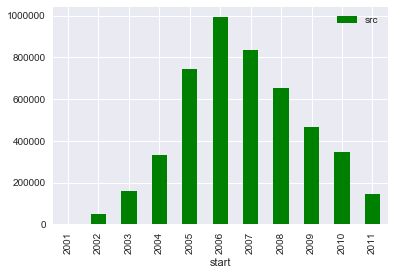

In [10]:
#plot that shows how many links are added in each year
temp_nw['src'].groupby(temp_nw["start"].dt.year).count().plot(kind="bar", legend=True, color = 'green')
plt.show()

The histogram looks like a bell curve. This means that most of the links are added in the years 2005-2008. Let's look if the removal of the links also have a bell shaped curve. 

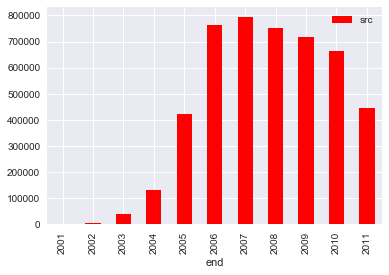

In [11]:
#plot that shows how many links are removed in each year
temp_nw['src'].groupby(temp_nw["end"].dt.year).count().plot(kind="bar", legend=True, color='red')
plt.show()

The histogram doesn't look like a bell curve. We actually see that the years 2006-2010 are the years in which most of the edges are removed. If we combine this with the information found above, we can conclude that the years 2006-2008 where the years in which the most links are added ánd removed from the wiki page. One can also be interested in the time duration of each link, i.e. how many years a link stays in the graph until it is removed. 

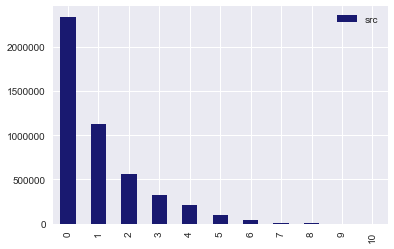

In [12]:
#plot which shows how many years each link remains in the graph bevore it is removed.
temp_nw['src'].groupby((temp_nw['end'].dt.year - temp_nw['start'].dt.year)).count().plot(kind="bar", legend=True, color='midnightblue')
plt.show()

From the histogram above we can see that a lot of links have a very short time duration in the graph. Most of the links are added and removed from the wiki page within a year. Furthermore we see that the other links doesn't stay long either in the graph. We can say that most of the links are zero to two years in the network.

### plot for average neighbor degree network

In [13]:
def total_average__neighbor_deg_per_year(df_temporal, t_1_year, t_2_year):
    t_1 = datetime.datetime(t_1_year, 1, 1, 0, 0, 0)
    t_2 = datetime.datetime(t_2_year, 1, 1, 0, 0, 0)
 
    df_year = df_temporal.loc[((df_temporal['start'] >= t_1) & (df_temporal['start'] < t_2)) | ((df_temporal['end'] >= t_1) & (df_temporal['end'] < t_2))]
    G_year = nx.from_pandas_dataframe(df_year, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    average_deg = nx.average_neighbor_degree(G_year, source='out', target='in')
    average_deg_graph = sum(average_deg.values()) / len(average_deg)
    time_interval = str(t_1_year)+"-"+str(t_2_year)

    return average_deg_graph

In [14]:
avg_neighbor_deg = { 'avg deg': [total_average__neighbor_deg_per_year(temp_nw, i, i+1) for i in range(2001,2012)], 'time_interval' : [str(i)+"-"+str(i+1) for i in range(2001,2012)]}
df_avg_neighbor_deg = pd.DataFrame(data=avg_neighbor_deg)

In [15]:
df_avg_neighbor_deg.head()

,avg deg,time_interval
0,0.083679,2001-2002
1,25.503060,2002-2003
2,21.423939,2003-2004
3,39.216190,2004-2005
4,213.583093,2005-2006


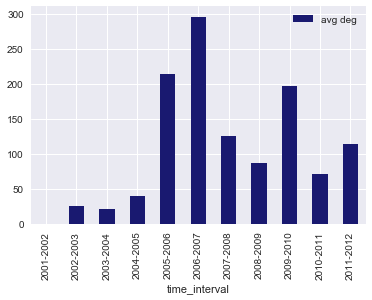

In [16]:
df_avg_neighbor_deg.plot.bar(x = 'time_interval', color='midnightblue');
plt.show()

The histogram shows us that the average neighbor degree in the temporal network is very high in the period 2005-2007 and 2006-2008. These are also the two periods where the network contains the most edges, therefore the average degree of each node increases. What is interesting, is that the degree in last two years are also quite high. This is interesting, because from the histograms above we say that these periods (2008-2010 and 2009-2011) are the periods where there are more links removed from the network then links that are added to the network. Therefore we would expect that the average degree of the neighbors would decrease, but the bar plot shows something differently.

### plot average degree of each node

In [17]:
def average_deg_full_graph(df_temporal, t_1_year, t_2_year):
    t_1 = datetime.datetime(t_1_year, 1, 1, 0, 0, 0)
    t_2 = datetime.datetime(t_2_year, 1, 1, 0, 0, 0)
    
    df_year = df_temporal.loc[((df_temporal['start'] >= t_1) & (df_temporal['start'] < t_2)) | ((df_temporal['end'] >= t_1) & (df_temporal['end'] < t_2))]
    G_year = nx.from_pandas_dataframe(df_year, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    average = sum(dict(G_year.out_degree()).values()) / float(nx.number_of_nodes(G_year))
    
    return average

In [18]:
avg_deg = { 'avg deg': [average_deg_full_graph(temp_nw, i, i+1) for i in range(2001,2012)], 'time_interval' : [str(i)+"-"+str(i+1) for i in range(2001,2012)]}
df_avg_deg = pd.DataFrame(data=avg_deg)

In [19]:
df_avg_deg.head()

,avg deg,time_interval
0,1.167268,2001-2002
1,2.955157,2002-2003
2,3.261176,2003-2004
3,3.377836,2004-2005
4,3.764729,2005-2006


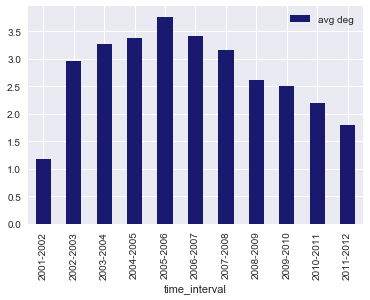

In [20]:
df_avg_deg.plot.bar(x = 'time_interval', color='midnightblue');
plt.show()